In [1]:
from dask.distributed import Client, LocalCluster
# from dask_jobqueue import SLURMCluster

# # cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='118GB', interface='ib0'
#                       )
# cluster.scale(120)
# # # cluster.adapt(minimum=1, maximum=48)

# client = Client(cluster)
client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:36693 Dashboard: http://127.0.0.1:45611/status,Cluster Workers: 8 Cores: 56 Memory: 270.19 GB


In [2]:
!squeue -u tuchida

import time
nb_workers = 0
while True:
    nb_workers = len(client.scheduler_info()["workers"])
    if nb_workers >= 2:
        break
    time.sleep(1)
print(nb_workers)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          10562606      visu      viz  tuchida  R       5:37      1 n4368
8


In [3]:
import xarray as xr
import numpy as np
import xscale
import gsw
import os.path as op
from xhistogram.xarray import histogram as xhist

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
ddir = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02-S/'
xtra = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02X-S'
scratch = '/scratch/cnt0024/hmg2840/tuchida/temp'

In [5]:
g = 9.81
Ce = 1e-2
cp = 4e3
ys,ye = (2000-1,2500+1)
xs,xe = (2300-1,3100+1)
ncoars = 5
zchunk = 4
z10 = 6

dsmask = xr.open_dataset(op.join(ddir,'../eNATL60-I/mesh_mask_eNATL60_3.6.nc'), 
                         chunks={'z':zchunk}).isel(t=0)
maskT = dsmask.tmask.isel(z=slice(None,95),y=slice(ys,ye),x=slice(xs,xe))

In [6]:
At = (dsmask.e1t * dsmask.e2t).sel(y=slice(ys,ye),
                                   x=slice(xs,xe)).where(xr.DataArray(maskT[0].data, dims=['y','x']
                                                                     ) != 0.)
Au = (dsmask.e1u * dsmask.e2u).sel(y=slice(ys,ye),
                                   x=slice(xs,xe)).where(xr.DataArray(maskT[0].data, dims=['y','x']
                                                                     ) != 0.)
Av = (dsmask.e1v * dsmask.e2v).sel(y=slice(ys,ye),
                                   x=slice(xs,xe)).where(xr.DataArray(maskT[0].data, dims=['y','x']
                                                                     ) != 0.)
e1u = dsmask.e1u.sel(y=slice(ys,ye),x=slice(xs,xe)).where(xr.DataArray(maskT[0].data, dims=['y','x']
                                                                      ) != 0.)
# e2u = dsmask.e2u[0].sel(y=slice(ys,ye),x=slice(xs,xe))
# e1v = dsmask.e1v[0].sel(y=slice(ys,ye),x=slice(xs,xe))
e2v = dsmask.e2v.sel(y=slice(ys,ye),x=slice(xs,xe)).where(xr.DataArray(maskT[0].data, dims=['y','x']
                                                                      ) != 0.)
e2t = dsmask.e2t.sel(y=slice(ys,ye),x=slice(xs,xe)).where(xr.DataArray(maskT[0].data, dims=['y','x']
                                                                      ) != 0.)
e1t = dsmask.e1t.sel(y=slice(ys,ye),x=slice(xs,xe)).where(xr.DataArray(maskT[0].data, dims=['y','x']
                                                                      ) != 0.)
gdepw = xr.open_dataset(op.join(scratch,'gdepw_eNATL60.nc')
                       ).gdepw.sel(y=slice(ys,ye),x=slice(xs,xe))
# e3t = dsmask.e3t_1d[0]
# e3w = dsmask.e3w_1d[0]

In [7]:
cori = xr.apply_ufunc(gsw.f, dsmask.nav_lat.isel(y=slice(ys,ye),x=slice(xs,xe)),
                      dask='parallelized', output_dtypes=[float,])
Atb = At.isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars}, boundary='trim').sum(skipna=True)
fb = xr.apply_ufunc(gsw.f, (dsmask.nav_lat.isel(y=slice(ys+1,ye-1),x=slice(xs+1,xe-1))
                            * At.isel(y=slice(1,-1),x=slice(1,-1))
                           ).coarsen({'y':ncoars,'x':ncoars}, boundary='trim').sum() / Atb,
                    dask='parallelized', output_dtypes=[float,]
                   )
e1tb = e1t.isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum(skipna=True)
e2tb = e2t.isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum(skipna=True)
Aub = Au.isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars}, boundary='trim').sum(skipna=True)
Avb = Av.isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars}, boundary='trim').sum(skipna=True)
# Atb = At.coarsen({'y':5,'x':5}, boundary='trim').sum()

In [7]:
# def filt(da, area=None):
    
# #     if area is not None:
#         win_2D = (da * area).window
#     else:
#         win_2D = da.window
    
#     win_2D.set(window='hanning', cutoff=20, dim=['y','x'], n=[30,30])
#     bw = win_2D.boundary_weights(drop_dims=[])
#     da_LS = win_2D.convolve(weights=bw)
    
#     if area is not None:
#         area_win = area.window
#         area_win.set(window='hanning', cutoff=20, dim=['y','x'], n=[30,30])
#         bw = area_win.boundary_weights(drop_dims=[])
#         da_LS *= area_win.convolve(weights=bw)**-1
    
#     da_SS = da - da_LS
    
#     return da_SS

In [8]:
xr.open_dataset(op.join(ddir,'00658801-00669600/eNATL60-BLBT02_1h_20091102_20091106_gridW_20091102-20091102.nc'),
               chunks=({'time_counter':1,'depthw':1})).sel(depthw=slice(None,510)).vovecrtz[0,0].data.nbytes*1e-6

158.024264

In [9]:
dsW = xr.open_mfdataset(op.join(ddir,'00658801-00669600/eNATL60-BLBT02_1h_20091102_20091106_gridW_200911*.nc'),
                        chunks={'time_counter':1,'depthw':1}, combine='by_coords'
                       ).sel(depthw=slice(None,510))
dsT = xr.open_mfdataset(op.join(ddir,'00658801-00669600/eNATL60-BLBT02_1h_20091102_20091106_gridT_200911*.nc'),
                        chunks={'time_counter':1,'deptht':1}, combine='by_coords'
                       ).sel(deptht=slice(None,510))
dsS = xr.open_mfdataset(op.join(ddir,'00658801-00669600/eNATL60-BLBT02_1h_20091102_20091106_gridS_200911*.nc'),
                        chunks={'time_counter':1,'deptht':1}, combine='by_coords'
                       ).sel(deptht=slice(None,510))
dsW

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, depthw: 74, time_counter: 120, x: 8354, y: 4729)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
  * depthw                (depthw) float32 0.0 1.0000261 ... 487.90018 500.50638
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2009-11-02T00:30:00 ... 2009-11-06T23:30:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    depthw_bounds         (time_counter, depthw, axis_nbounds) float32 dask.array<chunksize=(24, 1, 2), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    vovecrtz              (time_counter, depthw, y, x) float32 dask.array<chunksize=(1, 1, 4729, 8354), meta=np.ndarray>
Attributes:
    name:         /scratch/tmp/5091688/eNATL60-BLBT02_1h_20091102_20091106_gridW
    description:  ocean W grid variables
    title:        ocean W grid variables
    Conventions:  CF-1.6
    timeStamp:    2019-Mar-09 11:57:06 GMT
    uuid:         b541dd09-f592-4c7f-a4fa-0e01f9b6bcfa
    ibegin:       0
    ni:           8354
    jbegin:       0
    nj:           10
    file_name:    eNATL60-BLBT02_1h_20091102_20091106_gridW_20091102-20091102.nc
    TimeStamp:    10/03/2019 00:59:17 +0100

In [10]:
maskT = dsmask.tmask[0].sel(y=slice(ys,ye),x=slice(xs,xe)).isel(z=slice(None,len(dsW.depthw)))
    
CT = dsT.votemper.sel(y=slice(ys,ye),x=slice(xs,xe)
                     ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']).chunk({'deptht':1})!=0.
                            )
SA = dsS.vosaline.sel(y=slice(ys,ye),x=slice(xs,xe)
                     ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']).chunk({'deptht':1})!=0.
                            )
w = dsW.vovecrtz.sel(y=slice(ys,ye),x=slice(xs,xe)
                    ).where(xr.DataArray(maskT.data, dims=['depthw','y','x']).chunk({'deptht':1})!=0.
                           )

buoy = -g*xr.apply_ufunc(gsw.sigma0, SA, CT, 
                         dask='parallelized', output_dtypes=[float,]
                        )*1e-3

ws = filt(w.chunk({'depthw':1}), area=At)
bs = filt(buoy.chunk({'deptht':1}), area=At)

wsbs = (ws.isel(depthw=slice(1,None)) 
        * bs.chunk({'deptht':-1}).interp({'deptht':ws.depthw.isel(depthw=slice(1,None)).data},
                                         method='linear').data
       )
wsbs

<xarray.DataArray (time_counter: 120, depthw: 73, y: 500, x: 800)>
dask.array<mul, shape=(120, 73, 500, 800), dtype=float64, chunksize=(1, 1, 500, 800), chunktype=numpy.ndarray>
Coordinates:
  * depthw         (depthw) float64 1.0 2.157 3.471 4.943 ... 475.4 487.9 500.5
    nav_lat        (y, x) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2009-11-02T00:30:00 ... 2009-11-06T23:30:00
Dimensions without coordinates: y, x

In [ ]:
wsbs[:,15].mean('time_counter').plot(figsize=(12,7), vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')

In [ ]:
wsbs_b = ((wsbs*At).coarsen({'y':5,'x':5},boundary='trim').sum() 
          * At.coarsen({'y':5,'x':5},boundary='trim').sum()**-1
         )
s_b = ((SA*At).coarsen({'y':5,'x':5}, boundary='trim').sum()
       / At.coarsen({'y':5,'x':5}, boundary='trim').sum()
      )
t_b = ((CT*At).coarsen({'y':5,'x':5}, boundary='trim').sum()
       / At.coarsen({'y':5,'x':5}, boundary='trim').sum()
      )

z10 = 6
sig0_b = xr.apply_ufunc(gsw.sigma0, s_b, t_b, 
                        dask='parallelized', output_dtypes=[float,]
                       ).persist()
b_b = -g*sig0_b*1e-3

nMLD_b = z10 + np.abs((sig0_b.isel(deptht=slice(z10,None))
                       - sig0_b.isel(deptht=z10)
                      ) - 0.03).argmin(dim='deptht')

In [9]:
import dask.array as dsar
xr.concat([xr.DataArray(np.random.random((2,4)), dims=['time','x']).chunk({'time':1}),
           xr.DataArray(np.random.random((3,4)), dims=['time','x']).chunk({'time':1})], 'time')

<xarray.DataArray (time: 5, x: 4)>
dask.array<concatenate, shape=(5, 4), dtype=float64, chunksize=(1, 4), chunktype=numpy.ndarray>
Dimensions without coordinates: time, x

In [8]:
def filt(da, area=None):
    
    if area is not None:
        win_2D = (da * area).window
    else:
        win_2D = da.window
    
    win_2D.set(window='hanning', cutoff=20, dim=['y','x'], n=[30,30])
    bw = win_2D.boundary_weights(drop_dims=[])
    da_LS = win_2D.convolve(weights=bw)
    
    if area is not None:
        area_win = area.window
        area_win.set(window='hanning', cutoff=20, dim=['y','x'], n=[30,30])
        bw = area_win.boundary_weights(drop_dims=[])
        da_LS *= area_win.convolve(weights=bw)**-1
    
    da_SS = da - da_LS
    
    return da_SS

In [13]:
# dirs = np.arange(669601,756000,43200,dtype=int)
days = np.concatenate((np.arange(27,31,dtype=int), np.arange(1,17,dtype=int))).reshape((4,5))
# days = np.arange(17,32, dtype=int).reshape((3,5))
dirs = np.repeat(np.array([712801]),days.shape[0]+1)
print(days,dirs)

[[27 28 29 30  1]
 [ 2  3  4  5  6]
 [ 7  8  9 10 11]
 [12 13 14 15 16]] [712801 712801 712801 712801 712801]


In [17]:
month = 11
year = 2009
for k in range(0,len(dirs)-1):
    for i in days[k]:
        j = month
        l = j
        m = month+1
#         if k > 0:
#             j = m
        if i < days[0,0]:
            l = m

        d2D = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridT-2D_%4d%02d%02d-%4d%02d%02d.nc'
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'time_counter':1}
                             )
        d2Du = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridU-2D_%4d%02d%02d-%4d%02d%02d.nc'
                                       % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'time_counter':1}
                             )
        d2Dv = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridV-2D_%4d%02d%02d-%4d%02d%02d.nc'
                                       % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'time_counter':1}
                             )
        dsT = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridT_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'time_counter':1}
                             ).sel(deptht=slice(None,810))
        dsS = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridS_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'time_counter':1}
                             ).sel(deptht=slice(None,810))

        

        CT = dsT.votemper[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                 ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']
                                                     ) != 0.)
        SA = dsS.vosaline[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                 ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']
                                                     ) != 0.)
        ssh = d2D.sossheig[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                  ).where(xr.DataArray(maskT.data[0], dims=['y','x']
                                                      ) != 0.)
        taux = d2Du.sozotaux[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                    ).where(xr.DataArray(maskT.data[0], dims=['y','x']
                                                        ) != 0.)
        tauy = d2Dv.sometauy[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                    ).where(xr.DataArray(maskT.data[0], dims=['y','x']
                                                        ) != 0.)
        
        sig0 = xr.apply_ufunc(gsw.sigma0, SA, CT, 
                              dask='parallelized', output_dtypes=[float,])
        buoy = -g * sig0 * 1e-3
#         buoy = -g * (sig0+1e3-rho0) * rho0**-1
        bm = filt(buoy.chunk({'deptht':1}), area=At)

#######################
        nMLD = z10 + np.abs((sig0.isel(deptht=slice(z10,None))
                             - sig0.isel(deptht=z10)
                            ) - 0.03).argmin(dim='deptht').compute()
        
        e3t = dsmask.e3t_0.sel(y=slice(ys,ye),x=slice(xs,xe)) * (1+ssh*gdepw**-1)

        MLD = e3t.where(e3t.z<=nMLD.compute()).sum('z',skipna=True).compute()
        

        bmx = (bm.isel(x=slice(1,None))
               + bm.isel(x=slice(None,-1)).data
              ) * .5
        bmy = (bm.isel(y=slice(1,None))
               + bm.isel(y=slice(None,-1)).data
              ) * .5
        dbmx = bmx.diff(dim='x') * e1u.isel(x=slice(1,-1))**-1
        dbmy = bmy.diff(dim='y') * e2v.isel(y=slice(1,-1))**-1
        dbmxH = (dbmx.isel(y=slice(1,-1)) 
                 * xr.DataArray(e3t.isel(z=slice(len(dsT.deptht)),y=slice(1,-1),x=slice(1,-1)).data,
                                dims=['deptht','y','x'])
                ).where(dbmx.deptht <= MLD.isel(y=slice(1,-1),x=slice(1,-1))).sum('deptht',skipna=True)
        dbmyH = (dbmy.isel(x=slice(1,-1)) 
                 * xr.DataArray(e3t.isel(z=slice(len(dsT.deptht)),y=slice(1,-1),x=slice(1,-1)).data,
                                dims=['deptht','y','x'])
                ).where(dbmx.deptht <= MLD.isel(y=slice(1,-1),x=slice(1,-1))).sum('deptht',skipna=True)
        
        EBF = (tauy.isel(y=slice(1,-1),x=slice(1,-1)) * dbmxH
               - taux.isel(y=slice(1,-1),x=slice(1,-1)) * dbmyH
              ) * (MLD*cori).isel(y=slice(1,-1),x=slice(1,-1))**-1*1e-3
        
        EBF_b = ((EBF*At.sel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                                    boundary='trim').sum(skipna=True)
                 * Atb**-1
                )

#####################  
        if i == days[0,0]:
            EBF_bar = EBF_b.compute()
            
        else:
            EBF_bar = xr.concat([EBF_bar, EBF_b.compute()],
                                 'time_counter')

        
#         client.restart()
        print(str(l)+'-'+str(i))
    

dsave = EBF_bar.to_dataset(name='EBF')
dsave.to_netcdf(op.join(scratch,'GulfStream/EBF_bar_24h_%4d-%02d-%02d_%02d-%02d.nc' 
                        % (year,j,days[0,0],m,days[-1,-1])))
    
#     if k < len(dirs)-2:
#         del BFK_bar

AttributeError: 'Dataset' object has no attribute 'sozotaux'

In [32]:
month = 5
year = 2010
for k in range(0,len(dirs)-1):
    for i in days[k]:
        j = month
        l = j
        m = month+0
#         if k > 0:
#             j = m
        if i < days[0,0]:
            l = m

        dsTflx = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_flxT_%4d%02d%02d-%4d%02d%02d.nc' 
                                         % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                            year,j,days[0,0],year,m,days[-1,-1],
                                            year,l,i,year,l,i)),
                                 chunks={'time_counter':1}
                                )
        dsT = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridT_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'time_counter':1}
                             ).isel(deptht=0)
        dsS = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridS_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'time_counter':1}
                             ).isel(deptht=0)


#         if i == days[0,0]:
        maskT = dsmask.tmask[0].sel(y=slice(ys,ye),x=slice(xs,xe))

        CT = dsT.votemper.sel(y=slice(ys,ye),x=slice(xs,xe)
                             ).where(xr.DataArray(maskT.data, dims=['y','x']
                                                 ) != 0.)
        SA = dsS.vosaline.sel(y=slice(ys,ye),x=slice(xs,xe)
                             ).where(xr.DataArray(maskT.data, dims=['y','x']
                                                 ) != 0.)
        qtot = dsTflx.qt_oce.sel(y=slice(ys,ye),x=slice(xs,xe)
                                ).where(xr.DataArray(maskT.data, dims=['y','x']
                                                    ) != 0.)
        stot = dsTflx.sowaflup.sel(y=slice(ys,ye),x=slice(xs,xe)
                                  ).where(xr.DataArray(maskT.data, dims=['y','x']
                                                      ) != 0.)
        alpha = xr.apply_ufunc(gsw.alpha, SA, CT, 0.,
                               dask='parallelized', output_dtypes=['float',])
        beta = xr.apply_ufunc(gsw.beta, SA, CT, 0.,
                              dask='parallelized', output_dtypes=['float',])
        sig0 = xr.apply_ufunc(gsw.sigma0, SA, CT, 
                              dask='parallelized', output_dtypes=[float,])
        Bo = g*(alpha * (-qtot) * ((sig0+1e3)*cp)**-1
                + beta * stot * SA
               )    # Positive values defined as destablizing conditions
        qs = filt(qtot, area=At)
        ss = filt(stot, area=At)
        Bos = filt(Bo, area=At)

#######################
        qs_b = ((qs*At).coarsen({'y':5,'x':5}, boundary='trim').sum()
                / At.coarsen({'y':5,'x':5}, boundary='trim').sum()
               )
        ss_b = ((ss*At).coarsen({'y':5,'x':5}, boundary='trim').sum()
                / At.coarsen({'y':5,'x':5}, boundary='trim').sum()
               )
        Bos_b = ((Bos*At).coarsen({'y':5,'x':5}, boundary='trim').sum()
                / At.coarsen({'y':5,'x':5}, boundary='trim').sum()
               )
        Bo_b = ((Bo*At).coarsen({'y':5,'x':5}, boundary='trim').sum()
                / At.coarsen({'y':5,'x':5}, boundary='trim').sum()
               )

    #     del SA, CT

#         z10 = 6        
#         sig0_b = xr.apply_ufunc(gsw.sigma0, s_b, t_b, 
#                                 dask='parallelized', output_dtypes=[float,]
#                                )
#         [rho0_b,alpha0_b,beta0_b] = xr.apply_ufunc(gsw.rho_alpha_beta, s_b, t_b, 0,
#                                                    dask='parallelized', output_dtypes=[float])
#         b_b = -g*sig0_b*1e-3



#         wsbsb_ML = wsbs_b.where(wsbs_b.depthw <= MLD)
#####################  
        if i == days[0,0]:
            qs_bar = qs_b.compute()
            ss_bar = ss_b.compute()
            Bos_bar = Bos_b.compute()
            Bot_bar = Bo_b.compute()
            
        else:
            qs_bar = xr.concat([qs_bar, qs_b.compute()],
                                 'time_counter')
            ss_bar = xr.concat([ss_bar, ss_b.compute()],
                                 'time_counter')
            Bos_bar = xr.concat([Bos_bar, Bos_b.compute()],
                                'time_counter') 
            Bot_bar = xr.concat([Bot_bar, Bo_b.compute()],
                                'time_counter') 

        
#         client.restart()
        print(str(l)+'-'+str(i))
    

dsave = qs_bar.to_dataset(name='q_ssub')
dsave['s_sub'] = ss_bar
dsave['Bo_sub'] = Bos_bar
dsave['Bo_tot'] = Bot_bar
dsave.to_netcdf(op.join(scratch,'GulfStream/SurfFlux_bar_%4d-%02d-%02d_%02d-%02d.nc' 
                        % (year,j,days[0,0],m,days[-1,-1])))
    
#     if k < len(dirs)-2:
#         del BFK_bar

5-6


distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-6903ec640f43b6eab4b0ac281ff98048', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-6903ec640f43b6eab4b0ac281ff98048', 0, 0, 0)
NoneType: None


5-7
5-8
5-9
5-10
5-11
5-12
5-13
5-14
5-15
5-16
5-17
5-18
5-19
5-20
5-21
5-22
5-23
5-24
5-25
5-26
5-27
5-28
5-29
5-30


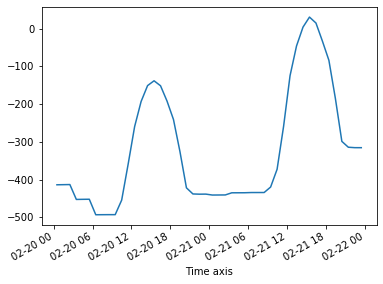

In [18]:
qtot_bar[:48].mean(['y','x']).plot()

In [13]:
month = 4
year = 2010
for k in range(0,len(dirs)-1):
    for i in days[k]:
        j = month
        l = j
        m = month+1
#         if k > 0:
#             j = m
        if i < days[0,0]:
            l = m
#         dsW = xr.open_dataset(op.join(ddir,'%08d-%08d/eNATL60-BLBT02_1h_2009%2d%02d_2009%2d%02d_gridW_2009%2d%02d-2009%2d%02d.nc' 
#                                       % (dirs[k],dirs[k+1]-1,j,days[k,0],11,days[k,-1],l,i,l,i)),
#                               chunks={'time_counter':1,'depthw':zchunk}
#                              ).sel(depthw=slice(None,510))
        dsT = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridT_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'time_counter':1,'deptht':zchunk}
                             ).sel(deptht=slice(None,510))
        dsS = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridS_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'time_counter':1,'deptht':zchunk}
                             ).sel(deptht=slice(None,510))

#         if i == days[0,0]:
        maskT = dsmask.tmask[0].sel(y=slice(ys,ye),x=slice(xs,xe)
                                    ).isel(z=slice(None,len(dsT.deptht)))

        CT = dsT.votemper[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                 ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']
                                                 ) != 0.)
        SA = dsS.vosaline[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                 ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']
                                                 ) != 0.)

#######################
        s_b = ((SA*At).coarsen({'y':5,'x':5}, boundary='trim').sum()
               / At.coarsen({'y':5,'x':5}, boundary='trim').sum()
              )
        t_b = ((CT*At).coarsen({'y':5,'x':5}, boundary='trim').sum()
               / At.coarsen({'y':5,'x':5}, boundary='trim').sum()
              )
    #     del SA, CT

        z10 = 6
        sig0_b = xr.apply_ufunc(gsw.sigma0, s_b, t_b, 
                                dask='parallelized', output_dtypes=[float,]
                               )
#         b_b = -g*sig0_b*1e-3

        nMLD_b = z10 + np.abs((sig0_b.isel(deptht=slice(z10,None))
                               - sig0_b.isel(deptht=z10)
                              ) - 0.03).argmin(dim='deptht')
        MLD = (xr.ones_like(sig0_b) * sig0_b.deptht
              )[{'deptht':nMLD_b.compute()}].compute()
        del nMLD_b, sig0_b
#         if i == days[0,0]:
#             MLD_b = MLD
#         else:
#             MLD_b = xr.concat([MLD_b, MLD], 'time_counter')


#######################    
        mu1 = 2*(-t_b.deptht) * MLD**-1 + 1
        mu1 = mu1.where(mu1.deptht <= MLD)
        mu = ((1.-mu1**2)*(1.+5/21*mu1**2)).chunk({'deptht':1})

        dtx = (t_b*e2tb).diff(dim='x', label='upper') * Aub[:,:-1]**-1
        dty = (t_b*e1tb).diff(dim='y', label='upper') * Avb[:-1]**-1
        dsx = (s_b*e2tb).diff(dim='x', label='upper') * Aub[:,:-1]**-1
        dsy = (s_b*e1tb).diff(dim='y', label='upper') * Avb[:-1]**-1

        dtx = (dtx.isel(x=slice(1,None))
               + dtx.isel(x=slice(None,-1)).data
              ) * .5
        dty = (dty.isel(y=slice(1,None)) 
               + dty.isel(y=slice(None,-1)).data
              ) * .5
        dsx = (dsx.isel(x=slice(1,None))
               + dsx.isel(x=slice(None,-1)).data
              ) * .5
        dsy = (dsy.isel(y=slice(1,None)) 
               + dsy.isel(y=slice(None,-1)).data
              ) * .5
        
        dtx = (dtx * xr.DataArray(e3t.data[:len(t_b.deptht)],dims=['deptht'])
              ).where(dtx.deptht <= MLD.isel(x=slice(1,-1))).sum('deptht') * MLD.isel(x=slice(1,-1))**-1
        dty = (dty * xr.DataArray(e3t.data[:len(t_b.deptht)],dims=['deptht'])
              ).where(dty.deptht <= MLD.isel(y=slice(1,-1))).sum('deptht') * MLD.isel(y=slice(1,-1))**-1
        dsx = (dsx * xr.DataArray(e3t.data[:len(s_b.deptht)],dims=['deptht'])
              ).where(dsx.deptht <= MLD.isel(x=slice(1,-1))).sum('deptht') * MLD.isel(x=slice(1,-1))**-1
        dsy = (dsy * xr.DataArray(e3t.data[:len(s_b.deptht)],dims=['deptht'])
              ).where(dsy.deptht <= MLD.isel(y=slice(1,-1))).sum('deptht') * MLD.isel(y=slice(1,-1))**-1
        
#         gradT2 = dtx.isel(y=slice(1,-1))**2 + dty.isel(x=slice(1,-1))**2
#         gradS2 = dsx.isel(y=slice(1,-1))**2 + dsy.isel(x=slice(1,-1))**2
    #     del b_b, dbx, dby

        tx2H = (Ce * mu.isel(y=slice(1,-1),x=slice(1,-1))
                * (dtx.isel(y=slice(1,-1)) * MLD.isel(y=slice(1,-1),x=slice(1,-1))**2) 
                * np.abs(fb).isel(y=slice(1,-1),x=slice(1,-1))**-1
               )
        ty2H = (Ce * mu.isel(y=slice(1,-1),x=slice(1,-1))
                * (dty.isel(x=slice(1,-1)) * MLD.isel(y=slice(1,-1),x=slice(1,-1))**2) 
                * np.abs(fb).isel(y=slice(1,-1),x=slice(1,-1))**-1
               )
        sx2H = (Ce * mu.isel(y=slice(1,-1),x=slice(1,-1))
                * (dsx.isel(y=slice(1,-1)) * MLD.isel(y=slice(1,-1),x=slice(1,-1))**2) 
                * np.abs(fb).isel(y=slice(1,-1),x=slice(1,-1))**-1
               )
        sy2H = (Ce * mu.isel(y=slice(1,-1),x=slice(1,-1))
                * (dsy.isel(x=slice(1,-1)) * MLD.isel(y=slice(1,-1),x=slice(1,-1))**2) 
                * np.abs(fb).isel(y=slice(1,-1),x=slice(1,-1))**-1
               )

#         wsbsb_ML = wsbs_b.where(wsbs_b.depthw <= MLD)
#####################  
        if i == days[0,0]:
            tx_bar = ((tx2H * xr.DataArray(e3t[:len(tx2H.deptht)], dims='deptht',
                                           coords={'deptht':tx2H.deptht.data}
                                          )
                      ).sum('deptht') * MLD.isel(y=slice(1,-1),x=slice(1,-1))**-1
                     ).compute()
            sx_bar = ((sx2H * xr.DataArray(e3t[:len(sx2H.deptht)], dims='deptht',
                                           coords={'deptht':sx2H.deptht.data}
                                          )
                      ).sum('deptht') * MLD.isel(y=slice(1,-1),x=slice(1,-1))**-1
                     ).compute()
            ty_bar = ((ty2H * xr.DataArray(e3t[:len(ty2H.deptht)], dims='deptht',
                                           coords={'deptht':ty2H.deptht.data}
                                          )
                      ).sum('deptht') * MLD.isel(y=slice(1,-1),x=slice(1,-1))**-1
                     ).compute()
            sy_bar = ((sy2H * xr.DataArray(e3t[:len(sy2H.deptht)], dims='deptht',
                                           coords={'deptht':sy2H.deptht.data}
                                          )
                      ).sum('deptht') * MLD.isel(y=slice(1,-1),x=slice(1,-1))**-1
                     ).compute()
            
        else:
            tx_bar = xr.concat([tx_bar, ((tx2H * xr.DataArray(e3t[:len(tx2H.deptht)], dims='deptht',
                                                              coords={'deptht':tx2H.deptht.data}
                                                             )
                                         ).sum('deptht') * MLD.isel(y=slice(1,-1),x=slice(1,-1))**-1
                                        ).compute()
                               ],
                               'time_counter')
            sx_bar = xr.concat([sx_bar, ((sx2H * xr.DataArray(e3t[:len(sx2H.deptht)], dims='deptht',
                                                              coords={'deptht':sx2H.deptht.data}
                                                             )
                                         ).sum('deptht') * MLD.isel(y=slice(1,-1),x=slice(1,-1))**-1
                                        ).compute()
                               ],
                               'time_counter')
            ty_bar = xr.concat([ty_bar, ((ty2H * xr.DataArray(e3t[:len(ty2H.deptht)], dims='deptht',
                                                              coords={'deptht':ty2H.deptht.data}
                                                             )
                                         ).sum('deptht') * MLD.isel(y=slice(1,-1),x=slice(1,-1))**-1
                                        ).compute()
                               ],
                               'time_counter')
            sy_bar = xr.concat([sy_bar, ((sy2H * xr.DataArray(e3t[:len(sy2H.deptht)], dims='deptht',
                                                              coords={'deptht':sy2H.deptht.data}
                                                             )
                                         ).sum('deptht') * MLD.isel(y=slice(1,-1),x=slice(1,-1))**-1
                                        ).compute()
                               ],
                               'time_counter')

        del MLD, tx2H, sx2H, ty2H, sy2H
        
#         client.restart()
        print(str(l)+'-'+str(i))
    

tx_bar.to_netcdf(op.join(scratch,'GulfStream/tx_bar-24h_%4d-%02d-%02d_%02d-%02d.nc' 
                         % (year,j,days[0,0],m,days[-1,-1])))
ty_bar.to_netcdf(op.join(scratch,'GulfStream/ty_bar-24h_%4d-%02d-%02d_%02d-%02d.nc' 
                         % (year,j,days[0,0],m,days[-1,-1])))
sx_bar.to_netcdf(op.join(scratch,'GulfStream/sx_bar-24h_%4d-%02d-%02d_%02d-%02d.nc' 
                         % (year,j,days[0,0],m,days[-1,-1])))
sy_bar.to_netcdf(op.join(scratch,'GulfStream/sy_bar-24h_%4d-%02d-%02d_%02d-%02d.nc' 
                         % (year,j,days[0,0],m,days[-1,-1])))
    
#     if k < len(dirs)-2:
#         del BFK_bar

4-11
4-12
4-13
4-14
4-15
4-16
4-17
4-18
4-19
4-20
4-21
4-22
4-23
4-24
4-25
4-26
4-27
4-28
4-29
4-30
5-1
5-2
5-3
5-4
5-5


In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
fig.set_tight_layout(True)
wsbsb_bar[0].plot(ax=ax1, vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
(BFK_bar[0]*.1).plot(ax=ax2, vmin=0, vmax=1e-7, cmap='Reds')

Future exception was never retrieved
future: <Future finished exception=KeyError("('open_dataset-8c8011d877bb9158a68f73e18ee7160ftime_centered-69fb9fe9e165d798f6407f2823effca1', 0)")>
Traceback (most recent call last):
  File "/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/distributed/client.py", line 1711, in _gather
    quiet_exceptions=AllExit,
  File "/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/distributed/utils.py", line 224, in All
    result = await tasks.next()
  File "/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/distributed/client.py", line 1700, in wait
    st = self.futures[k]
KeyError: "('mean_agg-aggregate-f137fcf5009adfa225ec68d5d477e33a', 0, 0)"

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.throw(*exc_in

In [ ]:
MLD_b.mean('time_counter').plot(vmax=1.4e2, vmin=20, cmap='Blues')

In [ ]:
wsbsb_ML.chunk({'depthw':-1}).mean(['time_counter','depthw']).plot(figsize=(8,5), cmap='RdBu_r', vmin=-1e-7, vmax=1e-7)

In [ ]:
fig, ax = plt.subplots(figsize=(14,4))
wsbs_bar.plot(ax=ax, c='r', lw=3)
gradbb2H_bar.plot(ax=ax, c='k', ls='--', lw=2)

In [ ]:
gradbb2H.name = 'BFK'
wsbsb_ML.name = 'wsbs'
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(20,5))
# fig.set_tight_layout(True)
gs = GridSpec(1,5,figure=fig)
ax1 = fig.add_subplot(gs[0,:2])
ax2 = fig.add_subplot(gs[0,2:4])
ax3 = fig.add_subplot(gs[0,4])
wsbsb_ML[0,14,1:-1,1:-1].plot(ax=ax1, vmax=5e-8, cmap='coolwarm', rasterized=True)
(1e2*gradbb2H[15,0]).plot(ax=ax2, vmin=0., vmax=5e-8, cmap='Reds', rasterized=True)
xhist(1e2*gradbb2H[1:].transpose('time_counter','deptht','y','x').chunk({'time_counter':1}), 
      wsbsb_ML[:,:,1:-1,1:-1].chunk({'time_counter':1}),
      bins=[np.logspace(-11,-6,30), np.logspace(-11,-6,30)]).plot(ax=ax3, cmap='Blues')
ax3.plot(np.linspace(1e-11,1e-6), np.linspace(1e-11,1e-6), c='grey', ls='--')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylim([1e-11,1e-6])
ax3.set_xlim([1e-11,1e-6])
ax3.set_xlabel(r"$\overline{w'b'}^{xy}$ [m$^2$ s$^{-3}$]", fontsize=14)
ax3.set_ylabel(r"$\frac{H_{\tt ML}^2|\nabla_{\tt H}\overline{b}^{xyz}|^2}{f}$ [m$^2$ s$^{-3}$]", 
               fontsize=14)
ax1.set_title(r"$\overline{w'b'}^{xy}$ [m$^2$ s$^{-3}$]", fontsize=15)
ax2.set_title(r"$H_{\tt ML}^2|\nabla_{\tt H}\overline{b}^{xyz}|^2 / f$ [m$^2$ s$^{-3}$]", 
             fontsize=15)
fig.suptitle(r"Nov. 2, 2009", fontsize=17, y=1.02)
# plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/Nov-2-2009_GulfStreamPatch.pdf')